In [1]:
%reload_ext autoreload
%autoreload 2

import notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.adjudication_multi_candidate_utils as acu
# or: from notebooks_utils import adjudication_multi_candidate_utils as acu  # also a module object

import importlib; importlib.reload(acu)   # works

<module 'notebooks_utils.data_notebooks_utils.adjudication_multi_candidate.adjudication_multi_candidate_utils' from '/Users/dorfuchs/Documents/Projects/main_project/over-intra-news/src/notebooks_utils/data_notebooks_utils/adjudication_multi_candidate/adjudication_multi_candidate_utils.py'>

# Security master, profile history, and S&P 500 membership

## 1. Overview

### 1.1 Background and motivation

The multi-candidate adjudication notebook produces a curated `ticker_cik_mapping` table with exactly one primary CIK per `(ticker, validity_window)` in the S&P 500 universe. This notebook builds on that output to construct three canonical, CIK-keyed layers:

1. A **security master** that defines the firm-level entity registry.
2. An **episodic profile history** that records company names (and lightweight descriptors) over time.
3. A **daily S&P 500 membership panel** that asserts index inclusion per CIK and trading day.

Together, these tables decouple firm identity, naming history, and index membership from noisy upstream sources (filings, snapshots, CSV feeds) and provide stable anchors for downstream research datasets such as prices, fundamentals, and news-returns alignment.

All three layers are keyed by the SEC Central Index Key (CIK), stored as a 10-digit zero-padded text string. Time-varying attributes use half-open date ranges `[start, end)` with explicit validity windows to support as-of joins.

### 1.2 Scope and outputs

This notebook is responsible for the following warehouse tables:

- **`security_master`**  
  Entity registry keyed by CIK. Exactly one row per firm in the research universe. No validity windows; all time-varying attributes live downstream.  
  **Output:** a populated `security_master` table containing every CIK that appears in `ticker_cik_mapping` (plus any additional CIKs that are needed for completeness).

- **`security_profile_history`**  
  Episodic profile table keyed by `(cik, validity_window)`. Stores company names (and optional lightweight descriptors) with explicit half-open `[start, end)` date ranges and non-overlap constraints per CIK.  
  **Output:** a set of non-overlapping name episodes per CIK, each with a canonical `company_name`, `source`, and a representative `evidence_id` for provenance.

- **`snp_membership`**  
  Daily S&P 500 membership panel keyed by `(cik, trading_day)`. Presence of a row implies that the firm was in the index on that NYSE trading day.  
  **Output:** a dense panel of `(cik, trading_day)` membership assertions derived by combining ticker-level S&P 500 snapshots with the curated `ticker_cik_mapping`.

The notebook encodes simple, deterministic rules for each layer and reserves a small, explicit manual surface (where necessary) for name conflicts and corner cases. Sanity checks at the end verify row counts and coverage of the S&P 500 universe.

### 1.3 Inputs and dependencies

This notebook assumes the following upstream tables and artifacts are already available:

- **`ticker_cik_mapping`**  
  Curated mapping from `(ticker, validity_window)` to a unique primary CIK, as produced by the multi-candidate adjudication notebook.

- **`ticker_cik_evidence`**  
  Evidence table keyed by `evidence_id` containing per-filing metadata (including CIK, filing dates, and company names) used to derive profile episodes and provenance links.

- **Daily S&P 500 membership snapshots**  
  Ticker-level index membership inputs (e.g., derived from the GitHub repository https://github.com/fja05680/sp500) that can be joined to the trading calendar and to `ticker_cik_mapping`.

- **`trading_calendar`**  
  Canonical NYSE trading calendar providing the set of valid `trading_day` values and supporting date-range joins.

The sections that follow construct each of the three target tables in turn:

1. Populate `security_master` from the curated CIK universe.
2. Derive and adjudicate `security_profile_history` episodes using evidence-backed company names.
3. Build `snp_membership` by combining daily ticker-level S&P snapshots with `ticker_cik_mapping` and the trading calendar, followed by basic consistency checks.


## 2. Security master

### 2.1 Purpose

The `security_master` table is the canonical entity registry for the research universe. It defines the set of firm-level entities as identified by SEC Central Index Keys (CIKs) and provides the anchor key that downstream episodic tables use for as-of logic:

- `ticker_cik_mapping` records which CIK is associated with a given `(ticker, validity_window)`.
- `security_profile_history` stores name history episodes per CIK.
- `snp_membership` records daily S&P 500 inclusion per CIK and trading day.
- Price, fundamentals, and news-linking layers are expected to key on CIK as well.

By construction, `security_master` is intentionally minimal: it stores only the CIK itself and enforces a format constraint. All time-varying and descriptive attributes live in separate, windowed tables.

### 2.2 Table definition

The table is defined once in the warehouse and reused across all downstream pipelines:

    -- Canonical entity registry keyed by SEC CIK
    CREATE TABLE IF NOT EXISTS security_master (

        -- CIK as the primary key (10-digit zero-padded string)
        cik TEXT PRIMARY KEY,

        -- Ensure CIK is numeric and zero-padded to 10 digits
        CONSTRAINT cik_numeric_and_padded CHECK (cik ~ '^[0-9]{10}$')
    );

    COMMENT ON TABLE security_master IS
    'Core reference table: one row per security in the research universe.';

    COMMENT ON COLUMN security_master.cik IS
    'Central Index Key (CIK), 10-digit zero-padded string, primary key';

Key properties:

- **Primary key:** `cik` (TEXT) — exactly one row per 10-digit, zero-padded CIK.
- **Format constraint:** a CHECK enforces `^[0-9]{10}$`, ruling out malformed or non-padded keys.
- **No timestamps or validity windows:** lineage and timing live in episodic tables such as `security_profile_history`, `ticker_cik_mapping`, and `snp_membership`.

### 2.3 Population strategy

The `security_master` table is populated from the curated CIK universe produced upstream:

- The primary source is **`ticker_cik_mapping`**, which already encodes the resolved `(ticker, validity_window) → CIK` relationships for the S&P 500 research universe.
- Optionally, additional CIKs can be unioned in from evidence tables (e.g., `ticker_cik_evidence`) if there is a need to extend the entity registry beyond the S&P 500 constituents.

The population logic is intentionally simple:

1. **Derive the CIK universe**  
   - Take the set of distinct CIKs appearing in `ticker_cik_mapping`.  

2. **Insert into `security_master`**  
   - Insert the derived CIK set into `security_master`.  
   - The operation should be **idempotent**: re-running it should not change existing rows, only add new CIKs if they appear in the upstream sources.

3. **Sanity checks**  
   - Verify that every CIK present in `ticker_cik_mapping` now has a corresponding row in `security_master`.  
   - Confirm that the CIK format constraint holds (any malformed CIKs will fail the CHECK and should be treated as upstream data-quality issues).

In [2]:
import pandas as pd
import sqlalchemy as sa
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import connect_with_sqlalchemy
import matplotlib.pyplot as plt

engine: sa.Engine = connect_with_sqlalchemy()
security_master_ingestion_query: str = """
INSERT INTO security_master (cik)
SELECT DISTINCT cik
FROM ticker_cik_mapping
ON CONFLICT (cik) DO NOTHING;
"""
if False: # Set to True to run
    with engine.begin() as conn:
        conn.execute(sa.text(security_master_ingestion_query))
mapping_query: str = """
SELECT DISTINCT cik FROM ticker_cik_mapping
WHERE cik NOT IN (SELECT cik FROM security_master);
"""
missing_ciks_df: pd.DataFrame = pd.read_sql(mapping_query, engine)
assert missing_ciks_df.empty, f"Missing CIKs in security_master: {missing_ciks_df['cik'].tolist()}"

## 3. Security profile history

### 3.1 Purpose

The `security_profile_history` table captures the **name history** of each firm in the research universe, keyed by SEC CIK. It provides a time-varying profile layer that can be joined as-of to prices, S&P 500 membership, and news, so that each historical record is labeled with the company name that was in effect at that time.

In this design, the CIK identifies the legal entity, and `security_profile_history` records how that entity is described over time. This makes it possible to:

- Attach a canonical company name to each `(cik, trading_day)` when building daily panels.
- Handle corporate rebrands and legal name changes (e.g., “Facebook, Inc.” → “Meta Platforms, Inc.”) via explicit, dated episodes.
- Keep the name layer separate from tickers and index membership, which have their own episodic tables.

### 3.2 Table definition and semantics

The table is defined once in the warehouse (see `security_profile_history.sql`) with the following key properties:

- **Primary key:** `(cik, validity_window)`  
  Each row represents a single **name episode** for one CIK over a half-open date span `[start, end)`.

- **Non-overlap per CIK:**  
  A GiST exclusion constraint enforces that `validity_window` ranges may **not overlap for the same CIK**. At any given date, a firm has at most one canonical name in this table.

- **Half-open date ranges:**  
  `validity_window` is a `DATERANGE` with `LOWER_INC = true` and `UPPER_INC = false`, non-empty and finite. As-of joins use predicates of the form  
  `trading_day <@ validity_window` to attach the appropriate episode to each date.

- **Name and source constraints:**  
  `company_name` is a trimmed, non-empty `TEXT` value. `source` is also a trimmed, non-empty `TEXT` value describing the origin of the profile data (e.g., “SEC 10-K parser”).

- **Entity and provenance links:**  
  - `cik` is a 10-digit, zero-padded text identifier and a foreign key to `security_master(cik)`.  
  - `evidence_id` is a foreign key to `ticker_cik_evidence(evidence_id)` and serves as a representative provenance key for the episode (for example, a filing whose header contains the name in `company_name`).  
  - `ingested_at` records when the profile episode was loaded.

Taken together, these constraints ensure that for any `(cik, date)` pair, there is either zero or one row in `security_profile_history`, and that row has a well-formed name and an explicit provenance trail back to the underlying evidence.

### 3.3 Population strategy

The population of `security_profile_history` is driven by evidence about how companies are named in filings and other structured sources:

1. **Collect candidate names per CIK**  
   - Start from the curated CIK universe in `security_master` and the mapping in `ticker_cik_mapping`.  
   - For each CIK, gather the set of names and filing dates from `ticker_cik_evidence` (or other profile sources) that are deemed reliable for naming (e.g., 10-K/20-F headers, selected 8-K items).

2. **Normalize and cluster names**  
   - Apply deterministic normalization (e.g., trimming whitespace, standardizing capitalization, optionally normalizing corporate designators like “Inc.” vs “Incorporated”).  
   - Group records by `(cik, normalized_name)` to identify clusters of evidence supporting the same underlying name.

3. **Propose episodes and resolve conflicts**  
   - For each `(cik, normalized_name)` cluster, derive a candidate `validity_window` from the earliest to the latest supporting date, using half-open `[start, end)` semantics.  
   - For CIKs with multiple candidate names whose windows overlap or interleave, perform a small amount of manual review to distinguish true legal name changes from formatting noise. This review results in a set of **non-overlapping episodes** per CIK, each with a chosen `company_name`, `validity_window`, `source`, and `evidence_id`.

4. **Insert episodes into `security_profile_history`**  
   - Insert the final, non-overlapping episodes per CIK into `security_profile_history`.

### 3.4 Interpretation of name changes and splits

Corporate rebrands and legal name changes are represented by **multiple episodes for the same CIK** with different names and adjacent, non-overlapping `validity_window`s. For example, a transition from “Facebook, Inc.” to “Meta Platforms, Inc.” is modeled as two distinct rows for the same CIK:

- One episode covering dates where the legacy name is in effect.
- A subsequent episode covering dates where the new name is in effect.

This approach keeps `security_profile_history` focused on a single **canonical name per CIK at any point in time**, while still capturing the full history of legal names needed for as-of labeling and downstream analysis.

### 3.5 Sanity checks

After constructing `security_profile_history`, the notebook performs basic consistency checks, such as:

- Every CIK in `security_master` that appears in downstream panels (e.g., S&P 500 membership) has at least one profile episode or is explicitly known to have no reliable naming data in the horizon of interest.  
- No two rows for the same CIK have overlapping `validity_window`s.  
- Each profile episode has a non-empty `company_name`, a non-empty `source`, and a valid `evidence_id` that links back to `ticker_cik_evidence`.

In [6]:
from typing import List
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import split_windows
from notebooks_utils.data_notebooks_utils.security_master_profiles_membership.\
  security_master_profiles_memberships_utils import (
    company_name_canonicalizer
)

entity_keys: List[str] = ['validity_window', 'candidate_cik']
instance_keys: List[str] = ['ticker', 'validity_window', 'candidate_cik']
evidence_query: str = """
SELECT evidence_table.*
FROM ticker_cik_evidence AS evidence_table
INNER JOIN ticker_cik_mapping AS mapping_table
  ON evidence_table.candidate_cik = mapping_table.cik
 AND evidence_table.ticker = mapping_table.ticker;
"""
evidence_df: pd.DataFrame = pd.read_sql(evidence_query, engine)
evidence_df = split_windows(evidence_df)
evidence_df['company_name'] = company_name_canonicalizer(evidence_df['company_name'])

#### 3.6 Name canonicalization and auto-accepted episodes

The raw `company_name` values in `ticker_cik_evidence` are noisy: they mix casing,
punctuation, and jurisdiction / corporate-form suffixes (e.g., “Inc.”, “PLC”, “L.P.”,
“MD”). Before deciding whether a given `(ticker, validity_window, candidate_cik)` triple
has a unique name, the notebook passes all `company_name` values through a
canonicalization function.

At a high level, `company_name_canonicalizer` performs the following steps:

1. **Normalize case and trim**

   - Convert the string to upper-case.
   - Strip leading and trailing whitespace.

2. **Strip lightweight punctuation**

   - Remove commas, ampersands, hyphens, forward slashes, and periods
     (anything matching the character class `[,&\-\/.]`).
   - This collapses variants such as `L.P.`, `L.P`, `L/P` into the same token.

3. **Remove corporate / jurisdictional suffixes**

   - Iterate through a fixed list `NAME_SUFFIXES_TO_REMOVE`, currently:

     INC, INCDE, INCMD, INCORPORATED,  
     CORP, CORPORATION,  
     INTERNATIONAL, GROUP, CO, COMPANY,  
     LLC, LP, L.P., LLLP, LLP,  
     LTD, LIMITED,  
     HOLDINGS, HLDGS, HOLDING,  
     PLC,  
     DE, MD, UT, MO

   - For each suffix, remove any occurrence that appears as a stand-alone token
     (optionally followed by a period). Examples:

     - `ACME INC`, `ACME INC.`, `ACME INC DE` → `ACME`
     - `TE CONNECTIVITY PLC` → `TE CONNECTIVITY`
     - `FOO LTD.` → `FOO`

   - The presence of composite entries such as `INCDE` and `INCMD` compensates for the
     earlier punctuation stripping, which turns `INC DE` into `INCDE`, `INC MD` into
     `INCMD`, and so on.

4. **Remove all remaining spaces**

   - Finally, remove all spaces so the canonical form is a single token. For example,
     `DELTA AIR LINES INC /DE/` becomes `DELTAAIRLINES`.

Putting this together, two raw names are treated as the same for our purposes if their
canonicalized strings match exactly after these transformations.

---

Operationally, the notebook applies this canonicalizer to every evidence row and then
aggregates at the `(ticker, validity_window, candidate_cik)` level.

1. **Build the evidence frame**

   The notebook constructs `evidence_df` from `ticker_cik_evidence` joined to
   `security_master` (to restrict to known CIKs) and passed through `split_windows` so
   that filing dates align with the S&P 500 validity windows. Conceptually:

       evidence_df
       ├─ ticker
       ├─ validity_window
       ├─ candidate_cik
       ├─ company_name        # raw issuer name from EDGAR
       └─ … other filing metadata …

2. **Canonicalize names**

   The canonicalizer is applied column-wise:

       evidence_df["company_name"] = company_name_canonicalizer(
           evidence_df["company_name"]
       )

3. **Count distinct canonical names per episode**

   Let

       keys = ["ticker", "validity_window", "candidate_cik"]

   For each triple, the notebook computes the number of distinct canonical names:

       name_counts_df = evidence_df.groupby(keys).agg(
           name_count=("company_name", "nunique")
       )

   Interpretation:

   - `name_count == 1` → all evidence filings for that
     `(ticker, validity_window, candidate_cik)` agree on the canonicalized company name.
   - `name_count > 1` → even after normalization, there is at least one conflict
     (typically a genuine rename inside the window, or inconsistent issuer strings).

4. **Auto-accepted name episodes**

   The **auto-accepted** set is defined as those episodes with `name_count == 1`:

       auto_pick_names_df = name_counts_df[
           name_counts_df["name_count"] == 1
       ].reset_index()

   Joining `auto_pick_names_df` back to `evidence_df` on `(ticker, validity_window,
   candidate_cik)` recovers the underlying filing metadata (including `evidence_id`,
   `company_name`, `source`, and `filed_at`) for each auto-accepted triple.

   For these episodes, the pipeline treats the (already canonical-consistent) name as
   the definitive firm name over the entire validity window. The corresponding rows in
   `security_profile_history` can be populated directly from the chosen evidence row
   (using its `company_name`, `source`, and `evidence_id`), without further manual
   intervention.

5. **Residual conflict set**

   The complement (`name_count > 1`) forms the **name conflict** set. These are the
   ~50–60 episodes that require manual review:

   - Some are genuine mid-window renames where the profile episode must be split into
     multiple non-overlapping windows with different names.
   - Others reflect upstream quirks, such as slightly different legal-entity strings
     that refer to the same operating company.

   Only this residual set is surfaced for hand adjudication; the bulk of the S&P 500
   universe is handled deterministically via the canonicalizer and the
   `name_count == 1` rule above.


In [7]:
from notebooks_utils.data_notebooks_utils.security_master_profiles_membership.\
    security_master_profiles_memberships_utils import (
    load_auto_accepted_names
)
name_counts_df: pd.DataFrame = evidence_df.groupby(entity_keys, sort=False).agg(
    name_count=('company_name', 'nunique')
)
auto_pick_names_df: pd.DataFrame = name_counts_df[name_counts_df['name_count'] == 1].reset_index()
auto_pick_names_df = auto_pick_names_df.merge(
    evidence_df,
    on=entity_keys,
    how='left'
)
load_auto_accepted_names(auto_pick_names_df) # Loads only if engine is not None and load_table is True

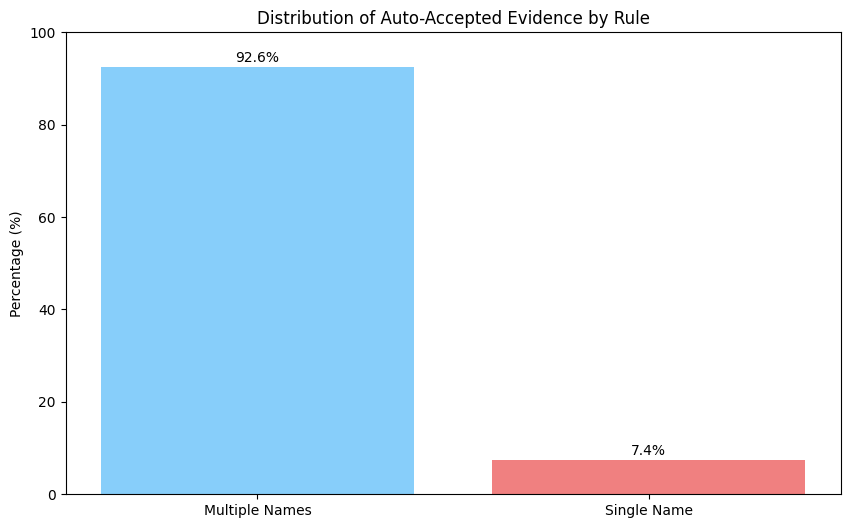

In [ ]:
labels: List[str] = ['Multiple Names', 'Single Name']
sizes: List[int] = [
    (name_counts_df['name_count'] == 1).sum(),
    (name_counts_df['name_count'] > 1).sum()
]
colors: List[str] = ['lightskyblue', 'lightcoral']
total: int = sum(sizes)
percentages = [(size / total) * 100 for size in sizes]
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=colors)
plt.title('Distribution of Company Name Counts')
plt.ylabel('Percentage (%)')
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 1, f"{percentage:.1f}%", ha="center", fontsize=10)
plt.ylim(0, 100)
plt.show()

In [ ]:
manual_review_names_df: pd.DataFrame = name_counts_df[name_counts_df['name_count'] > 1].reset_index()
manual_review_evidence_df: pd.DataFrame = manual_review_names_df.merge(
    evidence_df,
    on=entity_keys,
    how='left'
)
instance_groups = manual_review_evidence_df.groupby(instance_keys + ['company_name']).agg(
    min_filed_at=('filed_at', 'min'),
    max_filed_at=('filed_at', 'max'),
    evidence_count=('company_name', 'count')
)
instance_groups

min_filed_at  \
ticker validity_window          candidate_cik company_name                                                       
ADBE   [2016-08-01, 2025-08-02) 0000796343    ADOBE                                  2018-10-09 00:00:00+00:00   
                                              ADOBESYSTEMS                           2016-09-02 00:00:00+00:00   
AJG    [2016-08-01, 2025-08-02) 0000354190    ARTHURJGALLAGHER                       2019-10-25 00:00:00+00:00   
                                              GALLAGHERARTHURJ                       2016-10-28 00:00:00+00:00   
ANDV   [2016-08-01, 2018-10-01) 0000050104    ANDEAVOR                               2017-08-08 00:00:00+00:00   
...                                                                                                        ...   
ULTA   [2016-08-01, 2025-08-02) 0001403568    ULTASALONCOSMETICSFRAGRANCE            2016-08-25 00:00:00+00:00   
WMT    [2016-08-01, 2025-08-02) 0000104169    WALMART                                2018-02-01 00:00:00+00:00   
                                              WALMARTSTORES                          2016-08-31 00:00:00+00:00   
ZION   [2016-08-01, 2024-03-18) 0000109380    ZIONSBANCORPORATION                    2016-08-05 00:00:00+00:00   
                                              ZIONSBANCORPORATIONNATIONALASSOCIATION 2018-10-02 00:00:00+00:00   

                                                                                                  max_filed_at  \
ticker validity_window          candidate_cik company_name                                                       
ADBE   [2016-08-01, 2025-08-02) 0000796343    ADOBE                                  2025-06-25 00:00:00+00:00   
                                              ADOBESYSTEMS                           2018-09-26 00:00:00+00:00   
AJG    [2016-08-01, 2025-08-02) 0000354190    ARTHURJGALLAGHER                       2025-08-01 00:00:00+00:00   
                                              GALLAGHERARTHURJ                       2019-07-26 00:00:00+00:00   
ANDV   [2016-08-01, 2018-10-01) 0000050104    ANDEAVOR                               2018-09-18 00:00:00+00:00   
...                                                                                                        ...   
ULTA   [2016-08-01, 2025-08-02) 0001403568    ULTASALONCOSMETICSFRAGRANCE            2016-12-01 00:00:00+00:00   
WMT    [2016-08-01, 2025-08-02) 0000104169    WALMART                                2025-06-06 00:00:00+00:00   
                                              WALMARTSTORES                          2017-12-06 00:00:00+00:00   
ZION   [2016-08-01, 2024-03-18) 0000109380    ZIONSBANCORPORATION                    2018-08-08 00:00:00+00:00   
                                              ZIONSBANCORPORATIONNATIONALASSOCIATION 2024-02-23 00:00:00+00:00   

                                                                                      evidence_count  
ticker validity_window          candidate_cik company_name                                            
ADBE   [2016-08-01, 2025-08-02) 0000796343    ADOBE                                               41  
                                              ADOBESYSTEMS                                        11  
AJG    [2016-08-01, 2025-08-02) 0000354190    ARTHURJGALLAGHER                                    38  
                                              GALLAGHERARTHURJ                                    14  
ANDV   [2016-08-01, 2018-10-01) 0000050104    ANDEAVOR                                            15  
...                                                                                              ...  
ULTA   [2016-08-01, 2025-08-02) 0001403568    ULTASALONCOSMETICSFRAGRANCE                          2  
WMT    [2016-08-01, 2025-08-02) 0000104169    WALMART                                             35  
                                              WALMARTSTORES                                        8  

### 3.7 Examples of manual profile adjudication

The preceding sections describe how `security_profile_history` episodes are proposed from
aggregated evidence and then cleaned up via canonicalization. This section shows a few
representative manual adjudications for CIKs that still had multiple candidate company names
after the automatic steps.

Each example:

- Starts from a single `(ticker, validity_window, cik)` S&P 500 membership episode.
- Uses only the names as they appear in SEC forms (10-K/10-Q headers, 8-K items, etc.).
- Produces a small set of non-overlapping, half-open profile episodes keyed by `(cik, validity_window)`.

For brevity, the sketches below show only:

- `cik`
- `validity_window`
- `company_name`
- `source` (high-level provenance tag)

In the actual table, `evidence_id` and `ingested_at` are populated from the underlying
`ticker_cik_evidence` rows.

---

#### Example 1 — KLAC / KLA-Tencor Corporation → KLA Corporation (window split; legal rename)

**Type:** Window split based on a legal name change disclosed in a Form 8-K.  
**Ticker:** KLAC **CIK:** 0000319201 **Window:** `[2016-08-01, 2025-08-02)`

KLA’s S&P 500 membership window spans 2016-08-01 through 2025-08-02. Within that window,
SEC filings show two distinct legal names for the same registrant:

- The legacy name **“KLA-Tencor Corporation”**.
- The new name **“KLA Corporation”**.

A Form 8-K dated July 15, 2019 explains that KLA Corporation filed a certificate of amendment to
its certificate of incorporation changing its corporate name from “KLA-Tencor Corporation”
to “KLA Corporation,” effective on that date.

Using that 8-K as the authoritative cut point, we model two adjacent episodes:

    -- CIK 0000319201 (KLA)
    -- Columns shown: (cik, validity_window, company_name, source)

    ('0000319201', '[2016-08-01, 2019-07-15)', 'KLA-Tencor Corporation', 'edgar_fts'),
    ('0000319201', '[2019-07-15, 2025-08-02)', 'KLA Corporation',        'edgar_8k_name_change');

**Rationale summary:**

> Legal name change only; no change of issuer identity.  
> 8-K provides an explicit effective date (2019-07-15) for the rename.  
> Episodes are half-open, adjacent, and their union exactly covers the S&P window.

---

#### Example 2 — FBHS / Fortune Brands Home & Security, Inc. → Fortune Brands Innovations, Inc.

**Type:** Window split for a rebrand (same CIK, same economic issuer).  
**Ticker:** FBHS **CIK:** 0001519751 **Window:** `[2016-08-01, 2022-12-19)`

For this CIK, the filings within the S&P window use two legal names:

- **“Fortune Brands Home & Security, Inc.”**
- **“Fortune Brands Innovations, Inc.”**

A Form 8-K describes a charter amendment filed with the Delaware Secretary of State to change
the corporate name from “Fortune Brands Home & Security, Inc.” to
“Fortune Brands Innovations, Inc.,” effective as of December 15, 2022 (12:01 a.m. Eastern Time).

We treat this as a pure rename and align the split to that effective date:

    -- CIK 0001519751 (Fortune Brands)
    -- Columns shown: (cik, validity_window, company_name, source)

    ('0001519751', '[2016-08-01, 2022-12-15)', 'Fortune Brands Home & Security, Inc.', 'edgar_fts'),
    ('0001519751', '[2022-12-15, 2022-12-19)', 'Fortune Brands Innovations, Inc.',     'edgar_8k_name_change');

**Rationale summary:**

> 8-K explicitly states the legal rename and its effective date.  
> Both names refer to the same public company; ticker continuity confirms issuer continuity.  
> The second episode is truncated at the end of the S&P membership window.

---

#### Example 3 — J / Jacobs Engineering Group Inc. → Jacobs Solutions Inc.

**Type:** Window split for a holding-company reorganization with successor issuer.  
**Ticker:** J **CIK:** 0000052988 **Window:** `[2019-12-10, 2025-08-02)`

Jacobs appears in the S&P panel under ticker `J` with CIK 0000052988. Over the membership
window, the registrant name transitions from:

- **“Jacobs Engineering Group Inc.”**
- to **“Jacobs Solutions Inc.”**

A Form 8-K explains that, effective August 29, 2022, Jacobs Solutions Inc. (the “Holding Company”)
became the successor issuer to Jacobs Engineering Group Inc. under a holding-company
reorganization. Subsequent Forms 10-Q list “JACOBS SOLUTIONS INC.” as the exact name of the
registrant, with the same Commission File Number and ticker `J`.

We model this as a mid-window parent flip with a name change, but a single continuous issuer
identity for S&P purposes:

    -- CIK 0000052988 (Jacobs)
    -- Columns shown: (cik, validity_window, company_name, source)

    ('0000052988', '[2019-12-10, 2022-08-29)', 'Jacobs Engineering Group Inc.', 'edgar_fts'),
    ('0000052988', '[2022-08-29, 2025-08-02)', 'Jacobs Solutions Inc.',        'edgar_8k_reorg');

**Rationale summary:**

> Holding-company reorg with explicit “successor issuer” language.  
> Trading continues under ticker J; filings roll over to Jacobs Solutions Inc. with the same file number.  

---

#### Example 4 — LH / Laboratory Corporation of America Holdings → Labcorp Holdings Inc.

**Type:** Window split for a holding-company flip and rebrand.  
**Ticker:** LH **CIK:** 0000920148 **Window:** `[2016-08-01, 2025-08-02)`

Labcorp’s S&P membership window uses a single CIK, but filings show a structural change:

- Historically, the registrant name is **“LABORATORY CORPORATION OF AMERICA HOLDINGS”**.
- A 2024 Form 10-Q explains a planned holding-company structure under
  **“Labcorp Holdings Inc.”** to be implemented on May 17, 2024.
- Subsequent 8-Ks and 10-Qs refer to **“Labcorp Holdings Inc.”** as the registrant for ticker `LH`.

For profile history, we treat this as a single issuer identity with a mid-window parent/name change:

    -- CIK 0000920148 (Labcorp)
    -- Columns shown: (cik, validity_window, company_name, source)

    ('0000920148', '[2016-08-01, 2024-05-17)', 'Laboratory Corporation of America Holdings', 'edgar_fts'),
    ('0000920148', '[2024-05-17, 2025-08-02)', 'Labcorp Holdings Inc.',                     'edgar_8k_reorg');

**Rationale summary:**

> Reorganization moves the public listing into a new holding company but preserves issuer continuity.  
> We align the split to the legal effective date (2024-05-17) from the filings.  
> Name history remains one CIK with two adjacent episodes over the S&P window.

---

#### Example 5 — SYMC / NLOK / GEN — Symantec Corporation → NortonLifeLock Inc. → Gen Digital Inc.

**Type:** Multi-step rename chain modeled as three adjacent episodes.  
**CIK:** 0000849399  
**Relevant windows in the S&P panel:**

- `[2016-08-01, 2019-11-05)` (ticker `SYMC`)
- `[2019-11-05, 2022-11-08)` (ticker `NLOK`)
- `[2022-11-08, 2025-08-02)` (ticker `GEN`)

Across these windows, the same underlying issuer appears under three legal names:

1. **“Symantec Corporation”** (legacy name).  
2. **“NortonLifeLock Inc.”** (consumer-security rebrand).  
3. **“Gen Digital Inc.”** (post-merger global branding).

A 2019 Form 8-K documents the change from “Symantec Corporation” to
“NortonLifeLock Inc.” in connection with a business separation, with no new trading
entity created. A 2022 Form 8-K then records a further change of the corporate name from
“NortonLifeLock Inc.” to “Gen Digital Inc.,” effective November 7, 2022, with the ticker
switching from `NLOK` to `GEN` the next day.

Because both 8-Ks explicitly describe name changes rather than a new issuer, we keep all three
names under a single CIK and represent them as consecutive, half-open episodes:

    -- CIK 0000849399 (Symantec / NortonLifeLock / Gen Digital)
    -- Columns shown: (cik, validity_window, company_name, source)

    ('0000849399', '[2016-08-01, 2019-11-04)', 'Symantec Corporation', 'edgar_fts'),
    ('0000849399', '[2019-11-04, 2022-11-07)', 'NortonLifeLock Inc.',  'edgar_8k_name_change'),
    ('0000849399', '[2022-11-07, 2025-08-02)', 'Gen Digital Inc.',     'edgar_8k_name_change');

**Rationale summary:**

> Filings describe each step explicitly as a name change, not a change of reporting entity.  
> Ticker transitions (SYMC → NLOK → GEN) track the same underlying issuer’s equity.  
> Episodes are aligned to the effective dates in the 8-Ks and clipped to the S&P windows used in this project.

---

These examples are templates for the remaining manually adjudicated CIKs: for each
`(cik, validity_window)` pair in the conflict set, we pick the actual form names, identify
effective dates from high-signal filings, and hand-craft a short list of non-overlapping
`security_profile_history` episodes whose union matches the S&P horizon for that CIK.


In [ ]:
mapping_query: str = """
SELECT DISTINCT cik FROM security_master
WHERE cik NOT IN (SELECT DISTINCT cik FROM security_profile_history);
"""
missing_ciks_df: pd.DataFrame = pd.read_sql(mapping_query, engine)
assert missing_ciks_df.empty, f"Missing CIKs in security_profile_history: {missing_ciks_df['cik'].tolist()}"

## 4. S&P 500 membership panel (`snp_membership`)

### 4.1 Purpose

The `snp_membership` table is the **daily S&P 500 inclusion panel** keyed by CIK.  
Each row asserts that a given firm (identified by its 10-digit CIK) was a member of the
S&P 500 on a particular NYSE trading day.

This decouples **index membership** from both ticker symbols and company names:

- Tickers can change or move across issuers (handled in `ticker_cik_mapping`).
- Names can change over time (handled in `security_profile_history`).
- `snp_membership` focuses solely on “**was this CIK in the index on day D?**”.

Downstream datasets (prices, fundamentals, news exposures) can now join on
`(cik, trading_day)` without worrying about ticker churn.

---

### 4.2 Table definition (summary)

The warehouse table is defined once and then populated by this notebook:

    -- Daily S&P 500 inclusion keyed by (cik, trading_day)
    CREATE TABLE IF NOT EXISTS snp_membership (
        cik         TEXT NOT NULL
                    REFERENCES security_master (cik) ON DELETE CASCADE,
        trading_day DATE NOT NULL
                    REFERENCES trading_calendar (trading_day),
        source      TEXT NOT NULL,
        ingested_at TIMESTAMPTZ DEFAULT now(),
        CONSTRAINT snp_membership_pk
            PRIMARY KEY (cik, trading_day),
        CONSTRAINT snp_membership_cik_format
            CHECK (cik ~ '^[0-9]{10}$'),
        CONSTRAINT snp_membership_source_nonempty
            CHECK (trim(source) <> '')
    );

    -- “who’s in the index on day D?”
    CREATE INDEX IF NOT EXISTS snp_membership_trading_day_idx
    ON snp_membership (trading_day);

Key properties:

- **Primary key:** `(cik, trading_day)` — one row per firm per NYSE trading day.  
- **FKs:**  
  - `cik → security_master(cik)` to stay on the canonical entity spine.  
  - `trading_day → trading_calendar(trading_day)` to align with the NYSE calendar.  
- **Provenance:** `source` records the upstream feed / loader; `ingested_at` stamps load time.  
- **Append-only:** subsequent loads are idempotent via `ON CONFLICT DO NOTHING` on the PK.

---

### 4.3 Population strategy

Conceptually, the membership panel is derived by **exploding ticker-level S&P 500 windows**
onto the trading calendar and pushing them onto the CIK spine via `ticker_cik_mapping`:

1. Start from the curated `ticker_cik_mapping` table:
   - Each row is a `(ticker, cik, validity_window)` episode.
2. For each mapping episode, join to `trading_calendar` and generate one row per
   trading day inside the half-open `validity_window`:
   - `cal.trading_day <@ mapping.validity_window`
   - `cal.is_trading_day = true`
3. Insert `(cik, trading_day, source)` into `snp_membership`, using a fixed `source`
   label for this loader and `ON CONFLICT DO NOTHING` to keep ingestion idempotent.

In SQL, the load step is essentially:

    INSERT INTO snp_membership (cik, trading_day, source)
    SELECT DISTINCT
        m.cik,
        cal.trading_day,
        'sp500_membership_from_ticker_cik_mapping' AS source
    FROM ticker_cik_mapping AS m
    JOIN trading_calendar AS cal
      ON cal.is_trading_day
     AND cal.trading_day <@ m.validity_window
    ON CONFLICT (cik, trading_day) DO NOTHING;

This produces a dense panel of `(cik, trading_day)` pairs covering the full research
horizon wherever the corresponding S&P 500 ticker windows exist.


In [ ]:
snp_membership_query: str = """
INSERT INTO snp_membership (cik, trading_day, source)
SELECT DISTINCT
    m.cik,
    cal.trading_day,
    'sp500_membership_from_ticker_cik_mapping' AS source
FROM ticker_cik_mapping AS m
JOIN trading_calendar AS cal
  ON cal.is_trading_day
 AND cal.trading_day <@ m.validity_window
ON CONFLICT (cik, trading_day) DO NOTHING;
"""
if False: # Set to True to run
    with engine.begin() as conn:
        conn.execute(sa.text(snp_membership_query))

### 4.4 Sanity checks

After loading `snp_membership`, the notebook runs a small set of internal
consistency checks. These do not rely on any external reference index; instead,
they enforce that `snp_membership` is exactly the set of `(cik, trading_day)`
pairs implied by:

- the curated `ticker_cik_mapping` episodes, and  
- the NYSE `trading_calendar`.

Concretely, we check:

1. **No missing membership rows**  
   For every `(ticker, cik, validity_window)` episode and every NYSE trading day
   inside that window, there must be a corresponding row in `snp_membership`.

2. **No extra membership rows**  
   Every `(cik, trading_day)` in `snp_membership` must be supported by at
   least one `ticker_cik_mapping` episode whose `validity_window` covers
   `trading_day`.

3. **No non-trading days**  
   Every `trading_day` in `snp_membership` must be a trading day in
   `trading_calendar` (this is guaranteed by the loader logic, but we assert it
   explicitly as a guardrail).

In [ ]:
# 1) Expected membership that is missing from snp_membership
snp_membership_expected_missing: str = """
SELECT
    m.cik,
    cal.trading_day
FROM ticker_cik_mapping AS m
JOIN trading_calendar AS cal
  ON cal.is_trading_day
 AND cal.trading_day <@ m.validity_window
LEFT JOIN snp_membership AS sm
  ON sm.cik = m.cik
 AND sm.trading_day = cal.trading_day
WHERE sm.cik IS NULL;
"""

expected_missing_df: pd.DataFrame = pd.read_sql(
    snp_membership_expected_missing, engine
)
assert expected_missing_df.empty, (
    "Missing (cik, trading_day) rows in snp_membership "
    f"relative to ticker_cik_mapping + trading_calendar: "
    f"{expected_missing_df.to_dict(orient='records')}"
)

# 2) Membership rows that are not supported by any mapping episode
snp_membership_extraneous: str = """
SELECT
    sm.cik,
    sm.trading_day
FROM snp_membership AS sm
LEFT JOIN ticker_cik_mapping AS m
  ON m.cik = sm.cik
 AND sm.trading_day <@ m.validity_window
WHERE m.cik IS NULL;
"""

extraneous_df: pd.DataFrame = pd.read_sql(
    snp_membership_extraneous, engine
)
assert extraneous_df.empty, (
    "Found (cik, trading_day) rows in snp_membership that are "
    "not implied by ticker_cik_mapping: "
    f"{extraneous_df.to_dict(orient='records')}"
)

# 3) Membership rows on non-trading days (should not happen)
snp_membership_non_trading: str = """
SELECT
    sm.cik,
    sm.trading_day
FROM snp_membership AS sm
LEFT JOIN trading_calendar AS cal
  ON cal.trading_day = sm.trading_day
WHERE cal.is_trading_day IS NOT TRUE;
"""

non_trading_df: pd.DataFrame = pd.read_sql(
    snp_membership_non_trading, engine
)
assert non_trading_df.empty, (
    "Found snp_membership rows on non-trading days: "
    f"{non_trading_df.to_dict(orient='records')}"
)